In [1]:
# импорт
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import yaml

import warnings
warnings.filterwarnings("ignore")

# Описание задачи

https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks

Состав данных:
- **bookID**: идентификатор книги
- **title**: название книги
- **authors**: автор/авторы книги
- **average_rating**: рейтинг книги (на основе оценок пользователей) - **target**
- **isbn**: международный уникальный книжный номер
- **isbn13**: новый формат isbn, принятый в 2007 (13 цифр) 
- **language_code**: язык книги
- **num_pages**: количество страниц
- **ratings_count**: количество оценок книги
- **text_reviews_count**: количество отзывов на книгу
- **publication_date**: дата публикации
- **publisher**: издательство
- **genres**: жанр

Датасет содержит информацию о примерно 11 000 книгах. Данные позволяют предсказать рейтинг книги по её признаковому описанию. 

Полученное предсказание находит практическое применение среди издательств и онлайн библиотек. Высокий рейтинг книги определяет её популярность среди читателей. Следовательно, сервисы могут планировать закупки прав преимущественно на те книги, которые будут наиболее востребованны. 

## Чтение данных 

In [2]:
df = pd.read_csv('good_read_books.csv', on_bad_lines='skip')
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,genre
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,Fantasy
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,Fantasy
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,Fantasy
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,Fantasy
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,Fantasy


In [3]:
# размер датасета
df.shape

(11123, 13)

In [4]:
# проверка пропусков в данных и типов переменных признаков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
 12  genre               11028 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 1.1+ MB


Есть пропуски в признакe genre.

Некоторые признаки требуют изменения типа данных:
- language_code: object -> category
- publication_date: object -> datetime
- publisher: object -> category
- genre: object -> category

In [5]:
df.columns = df.columns.str.replace(' ', '')

In [6]:
# % пропусков
round((df.isnull().sum()/df.shape[0])*100,2)

bookID                0.00
title                 0.00
authors               0.00
average_rating        0.00
isbn                  0.00
isbn13                0.00
language_code         0.00
num_pages             0.00
ratings_count         0.00
text_reviews_count    0.00
publication_date      0.00
publisher             0.00
genre                 0.85
dtype: float64

Так как данных с пропусками мало (меньше 1%), то необходимо будет далее удалить эти строки из датасета

In [7]:
# описательные статистики для числовых данных
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


- Рейтинг (таргет) оценивается в диапазоне от 0 до 5.
- Количество страниц в книге изменяется в диапазоне от 6576 до 0. Предлагается удалить книги, содержащие 0 страниц.
- Для количества страниц 75% данных лежит в диапазоне до 416 страниц. При этом максимальное значение = 6576 - необходимо проверить, есть ли выбросы.
- Предлагается удалить данные с нулевым рейтингом (и следовательно нулевым количеством оценок), чтобы не искажать результаты дальнейшей модели (так как мы нацелены найти именно предсказание конкретного рейтинга). 

In [8]:
# описательные данных типа object
df.describe(include=['object'])

,title,authors,isbn,language_code,publication_date,publisher,genre
count,11123,11123,11123,11123,11123,11123,11028
unique,10348,6639,11123,27,3679,2290,218
top,The Iliad,Stephen King,0439785960,eng,10/1/2005,Vintage,Fiction
freq,9,40,1,8908,56,318,1856


- Несмотря на то, что уникальных заголовков меньше, чем всего объектов, это может быть ок (одна книга выпущенна в разное время разными издательствами)
- Количество уникальных языков = 27, наимболее популярный - английский
- Количество никальных издательств = 2290
- Количество жанров = 218

In [9]:
# поиск дубликатов, совпадающих по всем столбцам
duplicates = df[df.duplicated(keep=False)]
duplicates.shape

(0, 13)

Датасет не содержит дубликатов.

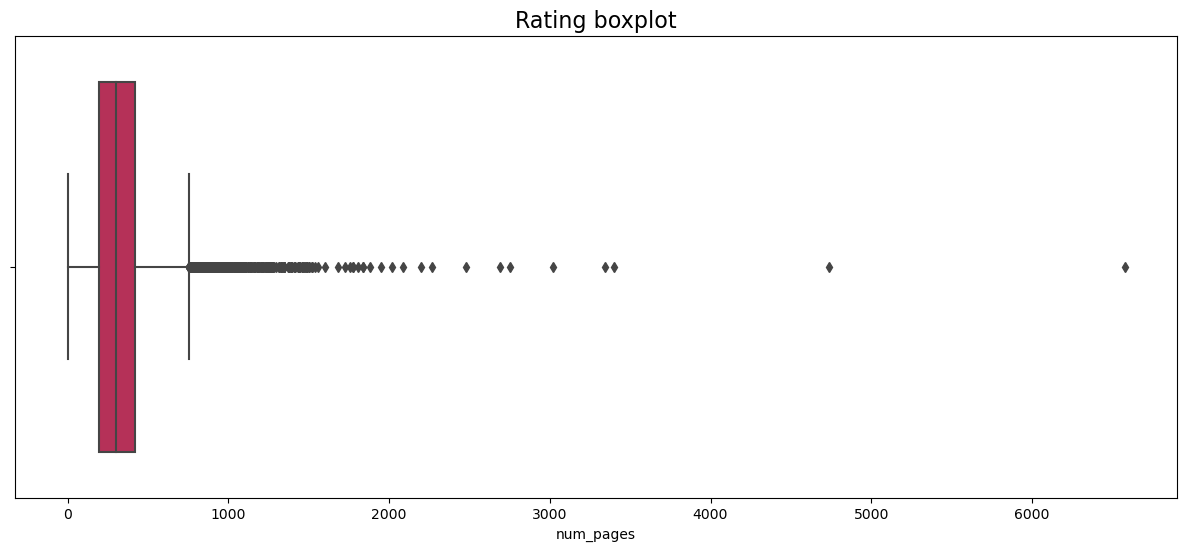

In [10]:
# поиск выбросов num_pages
plt.figure(figsize=(15, 6))
sns.boxplot(df.num_pages, palette='rocket')
plt.title('Rating boxplot', fontsize=16)

plt.show()

По boxplot определяем, что верхняя граница статистически значимой выборки = 900 страниц.

In [11]:
outliers = df[(df['num_pages'] > 900)]

In [12]:
# Проанализируем какую часть такие данные составляют от исходного датасета
print(f'Процент данных с выбросами = {round((outliers.shape[0]/df.shape[0])*100,2)} %')

Процент данных с выбросами = 2.64 %


Так как процент выбросов мал, далее удалим эти данные.

## Преобразование данных

- Изменение типов данных для некоторых признаков
- Удаление признаков: isbn, isbn13
- Удаление данных с пропуском в 'genre'
- Удаление данных с num_pages = 0
- Удаление данных с num_pages > 900
- Publication_date оставить только год
- Добавление нового признака с бинами на основе года публикации

In [13]:
# подгрузка параметров препроцессинга данных
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc = config['preprocessing']
preproc

{'change_type_century': {'century': 'str'},
 'change_type_columns': {'authors': 'category',
  'language_code': 'category',
  'publisher': 'category',
  'genre': 'category',
  'publication_year': 'int64',
  'century': 'category'},
 'date_transform': {'publication_date': 'publication_year'},
 'copy': {'publication_year': 'century'},
 'map_bins_columns': {'century': [[1950, 2000], ['20', '20.5', '21']]},
 'drop_columns': ['bookID',
  'isbn',
  'isbn13',
  'title',
  'publication_date',
  'text_reviews_count'],
 'train_path': '../data/processed/books_processed.csv',
 'unique_values_path': '../data/processed/unique_values.json',
 'test_size': 0.25,
 'target_column': 'average_rating',
 'random_state': 10,
 'train_path_proc': '../data/processed/train.csv',
 'test_path_proc': '../data/processed/test.csv',
 'raw_data_path': '../data/raw/books.csv'}

### Удаление объектов

In [14]:
# удаление данных с пропусками
df = df.dropna()
df.shape

(11028, 13)

In [15]:
# удаление данных, где num_pages = 0
df = df[df.num_pages != 0]
df.shape

(10957, 13)

In [16]:
# удаление данных, где average_rating = 0
df = df[df.average_rating != 0]
df.shape

(10935, 13)

In [17]:
# удаление данных, где ratings_count = 0
df = df[df.ratings_count != 0]
df.shape

(10885, 13)

In [18]:
# удаление данных, где num_pages > 900
df = df[df.num_pages < 900]
df.shape

(10598, 13)

In [19]:
# удаление данных, где ratings_count > 50000
df = df[df.ratings_count < 50000]
df.shape

(9953, 13)

In [20]:
df.to_csv(preproc['raw_data_path'], index=False)

### Преобразование признака publication_date 

In [21]:
# оставляем от даты публикации только год
df['publication_year'] = df.publication_date.str[-4:]

In [22]:
df['century'] = df['publication_year'].astype(int)

In [23]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,century
count,9953.000000,9953.000000,9.953000e+03,9953.000000,9953.000000,9953.000000,9953.000000
mean,21698.983221,3.933023,9.760288e+12,312.438863,4063.816538,190.329147,2000.061389
std,13051.237885,0.293214,4.384011e+11,173.157510,8138.895175,391.991691,8.353039
min,4.000000,1.000000,8.987060e+09,1.000000,1.000000,0.000000,1900.000000
25%,10814.000000,3.770000,9.780345e+12,192.000000,99.000000,9.000000,1998.000000
50%,21276.000000,3.950000,9.780618e+12,288.000000,622.000000,41.000000,2003.000000
75%,32414.000000,4.120000,9.780880e+12,400.000000,3534.000000,178.000000,2005.000000
max,45641.000000,5.000000,9.789999e+12,898.000000,49975.000000,5344.000000,2020.000000


### Создание бинов на основе года публикации

In [24]:
# создание бинов
bins = [1899, 1950, 2000, 2021]
century = ['20', '20,5', '21']
df['century'] = pd.cut(df['century'], bins, labels=century)
df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,genre,publication_year,century
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,Fantasy,2003,21
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,Fiction,2005,21
7,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,254,11/1/2005,Gramercy Books,Science Fiction,2005,21
9,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,Science Fiction,2004,21
10,16,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,0739322206,9780739322208,eng,6,1266,253,3/23/2005,Random House Audio,Science Fiction,2005,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11118,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press,Fantasy,2004,21
11119,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books,Fantasy,1988,"20,5"
11120,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books,Fantasy,1993,"20,5"
11121,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco,Fiction,2007,21


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9953 entries, 2 to 11122
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   bookID              9953 non-null   int64   
 1   title               9953 non-null   object  
 2   authors             9953 non-null   object  
 3   average_rating      9953 non-null   float64 
 4   isbn                9953 non-null   object  
 5   isbn13              9953 non-null   int64   
 6   language_code       9953 non-null   object  
 7   num_pages           9953 non-null   int64   
 8   ratings_count       9953 non-null   int64   
 9   text_reviews_count  9953 non-null   int64   
 10  publication_date    9953 non-null   object  
 11  publisher           9953 non-null   object  
 12  genre               9953 non-null   object  
 13  publication_year    9953 non-null   object  
 14  century             9953 non-null   category
dtypes: category(1), float64(1), int64(5),

### Изменение типов данных 

In [26]:
def transform_types(data: pd.DataFrame, change_type_columns: dict) -> pd.DataFrame:
    """
    Изменение типа данных для признаков
    param data: датасет
    param change_type_columns: словарь с признаками и типами данных
    """
    
    return data.astype(change_type_columns, errors="ignore")



In [27]:
change_type_columns = preproc['change_type_columns']
change_type_columns

{'authors': 'category',
 'language_code': 'category',
 'publisher': 'category',
 'genre': 'category',
 'publication_year': 'int64',
 'century': 'category'}

In [28]:
change_type_columns = preproc['change_type_columns']
df = transform_types(data=df, change_type_columns=change_type_columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9953 entries, 2 to 11122
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   bookID              9953 non-null   int64   
 1   title               9953 non-null   object  
 2   authors             9953 non-null   category
 3   average_rating      9953 non-null   float64 
 4   isbn                9953 non-null   object  
 5   isbn13              9953 non-null   int64   
 6   language_code       9953 non-null   category
 7   num_pages           9953 non-null   int64   
 8   ratings_count       9953 non-null   int64   
 9   text_reviews_count  9953 non-null   int64   
 10  publication_date    9953 non-null   object  
 11  publisher           9953 non-null   category
 12  genre               9953 non-null   category
 13  publication_year    9953 non-null   int64   
 14  century             9953 non-null   category
dtypes: category(5), float64(1), int64(6),

# EDA

## Распределение целевой переменной - average_rating 

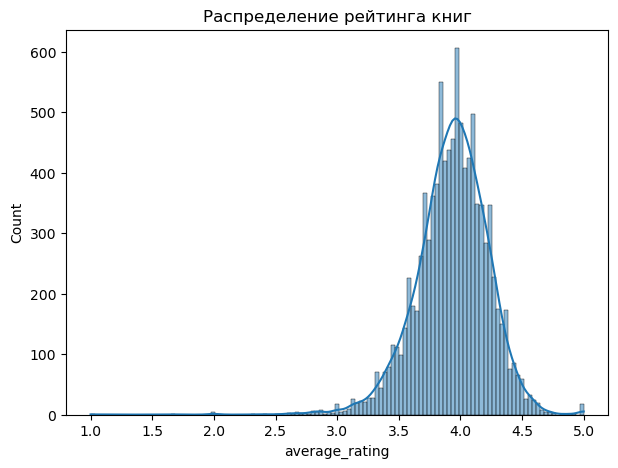

In [29]:
plt.figure(figsize=(7, 5))
sns.histplot(df.average_rating, kde=True)
plt.title('Распределение рейтинга книг')
plt.show()

Распределение рейтинга книг имеет вид нормального (mean = 3.93, std = 0.35).
Среднее значение рейтинга = 4 говорит о том, что людям свойственно ставить 'хорошие' оценки книгам. Практически отсутствуют оценки со значением [0, 2.5]. Основной разброс оценок книг в диапазоне от 3 до 5.

## Корреляция признаков 

<AxesSubplot:>

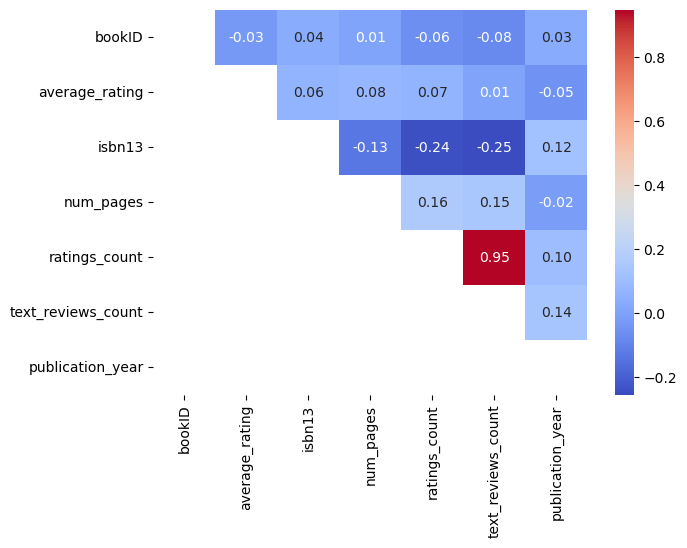

In [30]:
matrix = np.tril(df.corr(method='spearman'))

plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(method='spearman'), annot=True, 
            fmt='.2f', cmap='coolwarm', mask=matrix)

Признаки rating_count и text_reviews_count имеют высокую корреляцию. Для дальнейшего анализа исключим из рассмотрения признак text_reviews_count.

In [31]:
df = df.drop(columns=['text_reviews_count'], axis=1)
#df

## 1 Гипотеза

- Чем больше страниц содержится в книге, тем больше её рейтинг

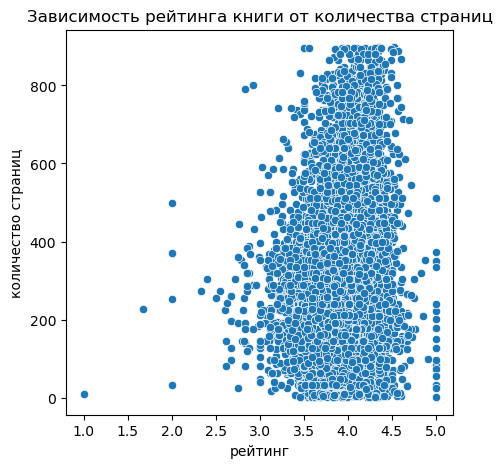

In [32]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, y='num_pages', x='average_rating')
plt.title('Зависимость рейтинга книги от количества страниц')
plt.xlabel('рейтинг')
plt.ylabel('количество страниц')
plt.show()

Явной связи между количеством страниц и рейтингом нет. Это также видно на heatmap: коэффициент корреляции = 0.08 - слабая положительная зависимость. Можно заметить, что книги с рейтингом > 4.5 преимущественно имеют число страниц меньше 400.

## 2 Гипотеза 

- Чем старее книга, тем выше рейтинг

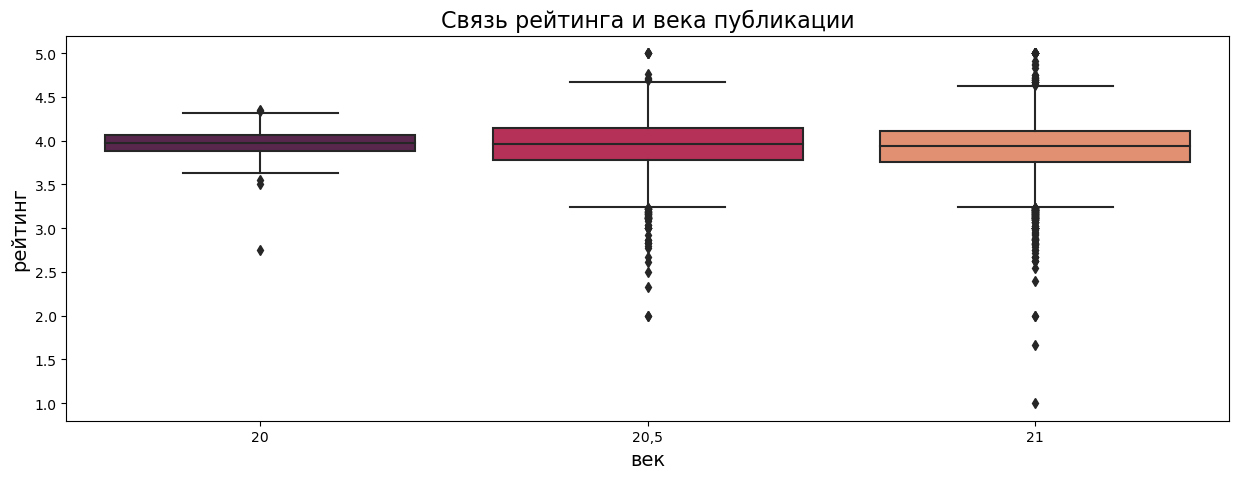

In [33]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='century', y='average_rating', data=df, palette='rocket')
plt.title('Связь рейтинга и века публикации', fontsize=16)
plt.xlabel('век', fontsize=14)
plt.ylabel('рейтинг', fontsize=14)
plt.show()

Для произведений первой половины 20-го века свойственно более высокое значение медианы, меньший межквантильный диапазон вместе с более узким диапазоном макс-мин значений. Это означает, что в этой группе книг оценки наиболее вероятно распределены около среднего рейтинга (рейтинга = 4). Для книг второй половины 20-го века и 21 века свойтвеннен практически одинаково широкое распредение рейтинга (от 3.3 до 4.7). Однако, медиана для группы книг 21 века лежит чуть ниже. 

## 3 Гипотеза

- Рейтинг зависит от жанра книги. Книги определенного жанра имеют заметный выигрыш в рейтинге.

In [34]:
genres_sort = df.groupby('genre')['title'].count().sort_values(ascending = False)
genres_sort

genre
Fiction             1638
Classics             822
Fantasy              758
Nonfiction           727
Mystery              505
                    ... 
Literary Fiction       1
Authors                1
Erotica                1
Language Arts          1
 1ST edition           1
Name: title, Length: 205, dtype: int64

In [35]:
# создаём датафрейм на основе агрегации
df_genre = genres_sort.to_frame().reset_index()

In [36]:
# отделяем основные жанры (где более 10 экземпляров)
main_genres = df_genre[df_genre.title >= 10]
main_genres_list = list(main_genres.genre)

In [37]:
# делаем замену в данных, где жанры имеют мало экземпляров
df.genre = df.genre.apply(lambda x: x if x in main_genres_list else 'No genre')

In [38]:
top_genres = df_genre[:10]
top_genres_list = list(top_genres.genre)

In [39]:
df_copy = df
df_copy.genre = df_copy.genre.apply(lambda x: x if x in top_genres_list else '0')

In [40]:
df_copy = df_copy[df_copy.genre != '0']
# df_copy

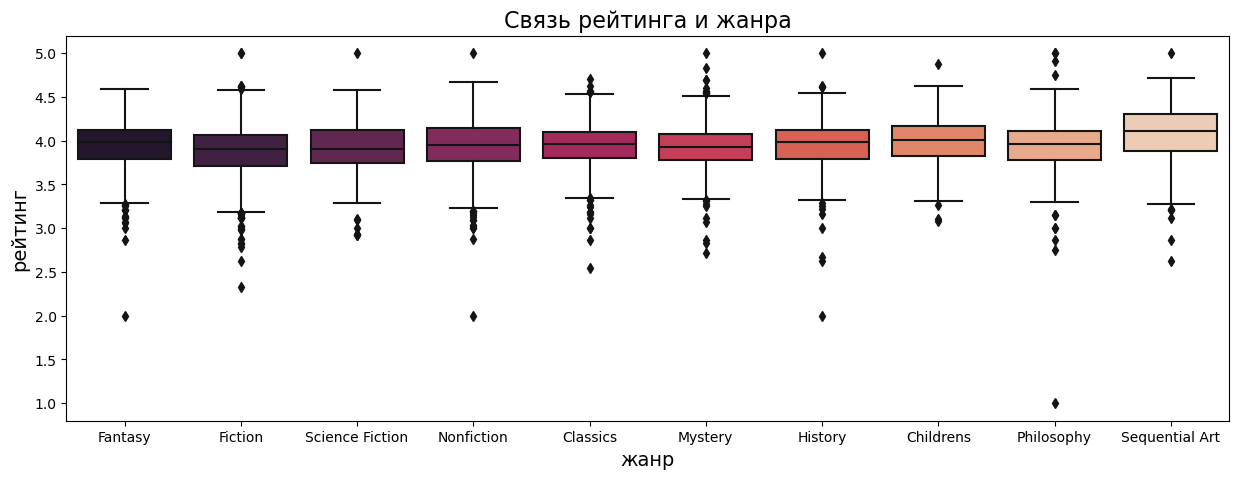

In [41]:
plt.figure(figsize=(15, 5))

sns.boxplot(x='genre', y='average_rating', data=df_copy, palette='rocket')
plt.title('Связь рейтинга и жанра', fontsize=16)
plt.ylabel('рейтинг', fontsize=14)
plt.xlabel('жанр', fontsize=14)
plt.show()

В среднем, среди топ10 популярных жанров показатели среднего рейтинга книг схожи. Однако, лидирующие позиции занимают книги, написанные в жанрах Fantasy и sequential art.

## 4 Гипотеза 

- Рейтинг связан с языком. Английские книги имеют более высокий рейтинг

In [42]:
lang_rating = df.groupby('language_code')['average_rating'].mean().sort_values(ascending = False)

In [43]:
language_sort = df.groupby('language_code')['title'].count().sort_values(ascending = False)

In [44]:
df_language = language_sort.to_frame().reset_index()
#df_language 

In [45]:
top_language = df_language[:5]
top_language_list = list(top_language.language_code)

In [46]:
df_copy_lang = df
df_copy_lang.language_code = df_copy_lang.language_code.apply(lambda x: x if x in top_language_list else '0')
df_copy_lang = df_copy_lang[df_copy_lang.language_code != '0']

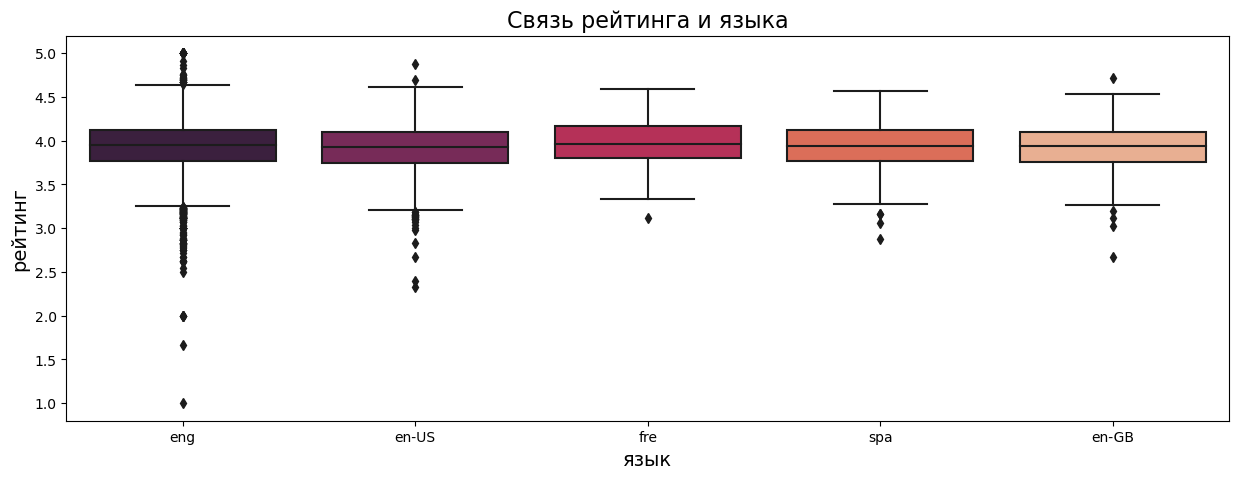

In [47]:
plt.figure(figsize=(15, 5))

sns.boxplot(x='language_code', y='average_rating', data=df_copy_lang, palette='rocket')
plt.title('Связь рейтинга и языка', fontsize=16)
plt.ylabel('рейтинг', fontsize=14)
plt.xlabel('язык', fontsize=14)
plt.show()

Показатели по среднему рейтингу очень близки и отображают общее распределение рейтинга по всему набору данных. Однако, можно отметить, что французские книги оценены выше всреднем. Для французских, испанских и британских книг диапазон максимальных-минимальных значений уже. В то время как для английских книг свойственны экстремально высокие (5 баллов) и низкие (<3 баллов) оценки.

# Сохранение уникальных значений 

In [48]:
df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,publication_date,publisher,genre,publication_year,century
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,11/1/2003,Scholastic,Fantasy,2003,21
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,4/26/2005,Nimble Books,Fiction,2005,21
7,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,11/1/2005,Gramercy Books,Science Fiction,2005,21
9,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,8/3/2004,Crown,Science Fiction,2004,21
10,16,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,0739322206,9780739322208,eng,6,1266,3/23/2005,Random House Audio,Science Fiction,2005,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11118,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,12/21/2004,Da Capo Press,Fantasy,2004,21
11119,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,12/1/1988,Penguin Books,Fantasy,1988,"20,5"
11120,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,8/1/1993,Penguin Books,Fantasy,1993,"20,5"
11121,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,2/27/2007,Ecco,Fiction,2007,21


In [49]:
def save_unique_train_data(
    data: pd.DataFrame, drop_columns: list, target_column: str, unique_values_path: str
) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями
    :param drop_columns: список с признаками для удаления
    :param data: датасет
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    
    unique_df = data.drop(
        columns=drop_columns + [target_column], axis=1, errors="ignore"
    )
    # создаем словарь с уникальными значениями для вывода в UI
    dict_unique = {key: unique_df[key].unique().tolist() for key in unique_df.columns}
    with open(unique_values_path, "w") as file:
        json.dump(dict_unique, file)


In [50]:
save_unique_train_data(
    data=df,
    drop_columns=preproc["drop_columns"],
    target_column=preproc["target_column"],
    unique_values_path=preproc["unique_values_path"],
)

In [51]:
df = df.drop(preproc["drop_columns"], axis=1, errors="ignore")

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9953 entries, 2 to 11122
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   authors           9953 non-null   category
 1   average_rating    9953 non-null   float64 
 2   language_code     9953 non-null   object  
 3   num_pages         9953 non-null   int64   
 4   ratings_count     9953 non-null   int64   
 5   publisher         9953 non-null   category
 6   genre             9953 non-null   object  
 7   publication_year  9953 non-null   int64   
 8   century           9953 non-null   category
dtypes: category(3), float64(1), int64(3), object(2)
memory usage: 851.5+ KB


In [53]:
df.to_csv(preproc['train_path'], index=False)